<a href="https://colab.research.google.com/github/cu2mauro/NN_matlab_bubble/blob/colabwork/ColabCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network to classify MATLAB bubble results

To build, train and test the CNN we use keras with the tensorflow backend.
Below we import the necessary modules.

In [177]:
import numpy as np #numerical
import pandas as pd #data analysis
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import scipy.io as sio
from scipy import interpolate
from scipy.interpolate import BSpline, make_interp_spline
import sys
%matplotlib inline
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from os.path import dirname, join as pjoin

In [ ]:
from google.colab import drive
drive.mount('/content/drive');

Load dataset: vectors of control points in X, actions in y.

In [183]:
mat = sio.loadmat('/content/drive/MyDrive/NN/NNtot')
data = mat['results']
X = np.reshape(np.vstack(data[:,0][:]),(len(data),12))
y = np.vstack(data[:,3][:])
X = np.expand_dims(np.reshape(np.c_[np.zeros(len(y)),X,np.zeros(len(y))],(len(y),2,7)), axis=3) # add zeros for first X and last Y coordinates, reshape

In [199]:
print(X.shape,y.shape)

(3501, 2, 7, 1) (3501, 1)


Divide dataset into training (80%), validation (10%) and test set (10%)



In [200]:
Ntot = len(X)
tot_ind = np.arange(Ntot)
random.shuffle(tot_ind)
val_ind = tot_ind[int(Ntot*0.8):int(Ntot*0.9)]
train_ind = tot_ind[0:int(Ntot*0.8)]
test_ind = tot_ind[int(Ntot*0.9):]

In [201]:
X_train = X[train_ind]
y_train = y[train_ind]
X_val = X[val_ind]
y_val = y[val_ind]
X_test = X[test_ind]
y_test = y[test_ind]

In [202]:
X_train.shape

(2800, 2, 7, 1)

What is our data: show border spline-curve control points, domain, and corresponding action

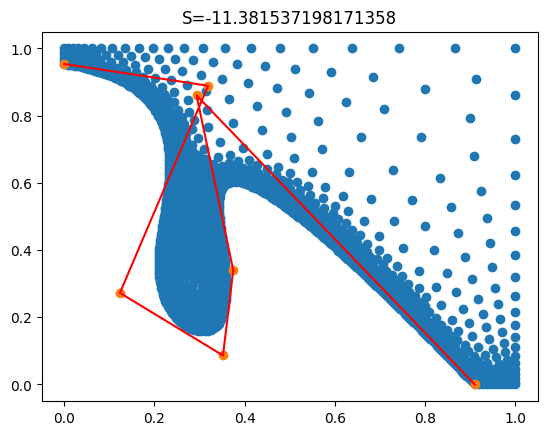

In [203]:
t = np.random.randint(len(X))
plt.scatter(np.transpose(data[t,1]['Points'][0][0])[0],np.transpose(data[t,1]['Points'][0][0])[1])
plt.scatter(X[t][0],X[t][1])
plt.plot(X[t][0],X[t][1],'r')
S = 'S='+str(y[t][0])
plt.title(S);
plt.show()

Build the CNN, compile and train/validate it

In [224]:
model = Sequential()
model.add(Conv2D(2, (2, 2), activation='relu', input_shape=(2, 7, 1), padding='same'))
model.add(Conv2D(4, (2, 2), activation='relu', padding='same'))
model.add(Conv2D(16, (2, 2), activation='relu'))
model.add(Flatten())
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(1))

In [225]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 2, 7, 2)           10        
                                                                 
 conv2d_55 (Conv2D)          (None, 2, 7, 4)           36        
                                                                 
 conv2d_56 (Conv2D)          (None, 1, 6, 16)          272       
                                                                 
 flatten_14 (Flatten)        (None, 96)                0         
                                                                 
 dense_29 (Dense)            (None, 48)                4656      
                                                                 
 dropout_14 (Dropout)        (None, 48)                0         
                                                                 
 dense_30 (Dense)            (None, 1)               

**Note:** training should be done on GPUs, if you are not running on GPUs skip this part and load the pretrained model

In [226]:
model.compile(loss=keras.losses.MeanSquaredError())

cnn_history = model.fit(X_train, y_train,
                        batch_size=64,
                        epochs=100,
                        verbose=1,
                        validation_data=(X_val, y_val))

Epoch 1/100
44/44 [==============================] - 4s 20ms/step - loss: 1221014.2500 - val_loss: 145475.4844
Epoch 2/100
44/44 [==============================] - 0s 7ms/step - loss: 1221010.8750 - val_loss: 145472.8125
Epoch 3/100
44/44 [==============================] - 0s 7ms/step - loss: 1221002.7500 - val_loss: 145469.4688
Epoch 4/100
44/44 [==============================] - 0s 5ms/step - loss: 1220998.2500 - val_loss: 145465.4219
Epoch 5/100
44/44 [==============================] - 0s 5ms/step - loss: 1220985.1250 - val_loss: 145460.6875
Epoch 6/100
44/44 [==============================] - 0s 5ms/step - loss: 1220981.5000 - val_loss: 145454.3281
Epoch 7/100
44/44 [==============================] - 0s 5ms/step - loss: 1220961.5000 - val_loss: 145445.5938
Epoch 8/100
44/44 [==============================] - 0s 5ms/step - loss: 1220924.7500 - val_loss: 145435.5625
Epoch 9/100
44/44 [==============================] - 0s 5ms/step - loss: 1220926.5000 - val_loss: 145423.2188
Epoch 10/

In [229]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score)
y_pred_cnn2 = model.predict(X_test)

Test accuracy: 180930.375
11/11 [==============================] - 0s 3ms/step
